In [1]:
# %%bash
!pip install tqdm

# # Move API key to where Kaggle expects it
# mv /home/ec2-user/SageMaker/SkinCancerCapstone/kaggle.json /home/ec2-user/.kaggle

# kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# unzip skin-cancer-mnist-ham10000.zip -d data

In [1]:
import numpy as np
import pandas as pd
import os, cv2, itertools
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [2]:
data_dir = os.path.join('..', 'data')
data_dir = 'data'
all_image_path = glob(os.path.join(data_dir, '*','*.jpg'))

# building dictionary of image id as key and file path as value
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

In [3]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    
    means_np = np.array(means)
    np.savez('means', means_np)
    
    stdevs_np = np.array(stdevs)
    np.savez('stdevs', stdevs_np)
    
    
    return means,stdevs

means, stdevs = compute_img_mean_std(all_image_path)

 82%|██████████████████████████████████████████████████████████████▉              | 8192/10015 [02:14<00:34, 52.86it/s]

KeyboardInterrupt: 

In [3]:
# Building dictionary for lesion types
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
#  Open the csv file
filepath = os.path.join(data_dir, 'HAM10000_metadata.csv')
df = pd.read_csv(filepath)
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [5]:
# Will need for model building
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.sample(5)

lesion_id      image_id   dx    dx_type   age     sex  \
8084  HAM_0001269  ISIC_0027582   nv      histo  40.0  female   
6668  HAM_0007017  ISIC_0030838   nv  follow_up  45.0  female   
3402  HAM_0002287  ISIC_0026891   nv  follow_up  55.0    male   
608   HAM_0000238  ISIC_0024910  bkl      histo  70.0  female   
1746  HAM_0003495  ISIC_0033524  mel      histo  85.0    male   

         localization                                          path  \
8084            trunk  data\HAM10000_images_part_1\ISIC_0027582.jpg   
6668          abdomen  data\HAM10000_images_part_2\ISIC_0030838.jpg   
3402  upper extremity  data\HAM10000_images_part_1\ISIC_0026891.jpg   
608              face  data\HAM10000_images_part_1\ISIC_0024910.jpg   
1746             back  data\HAM10000_images_part_2\ISIC_0033524.jpg   

                           cell_type  cell_type_idx  
8084                Melanocytic nevi              4  
6668                Melanocytic nevi              4  
3402                Melanocytic nevi              4  
608   Benign keratosis-like lesions               2  
1746                        Melanoma              5

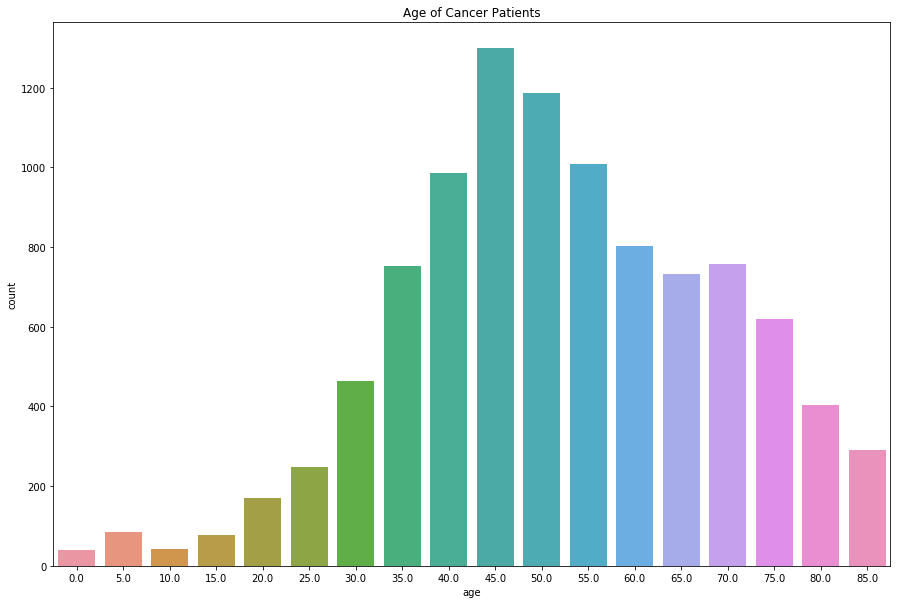

In [6]:
plt.figure(figsize = (15,10))
sns.countplot(df['age'])
plt.title('Age of Cancer Patients')
plt.show()

In [7]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [8]:
df['age'].fillna(int(df['age'].mean()), inplace = True)

In [9]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

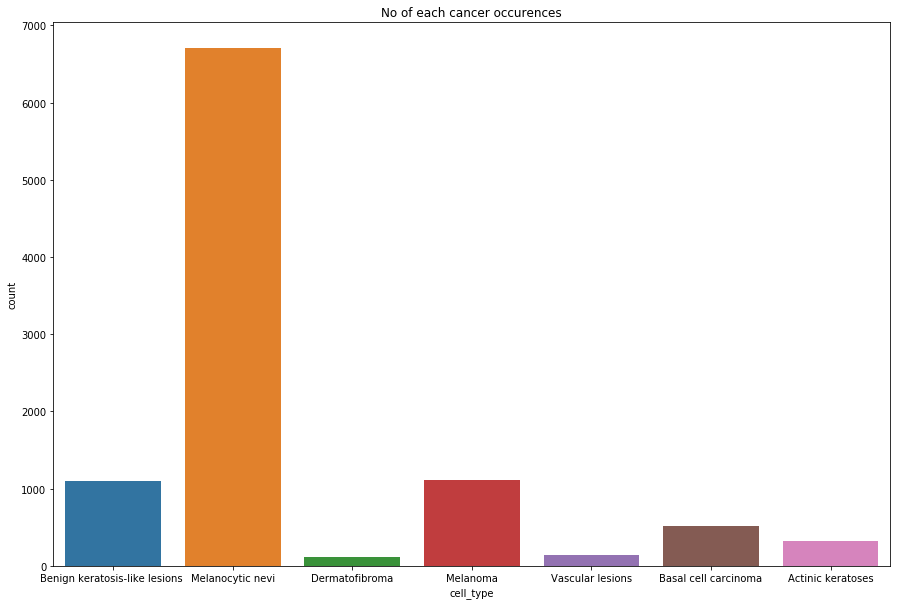

In [10]:
plt.figure(figsize = (15,10))
sns.countplot(df['cell_type'])
plt.title('No of each cancer occurences')
plt.show()

Text(0.5, 1.0, 'No of cancer occurences on body')

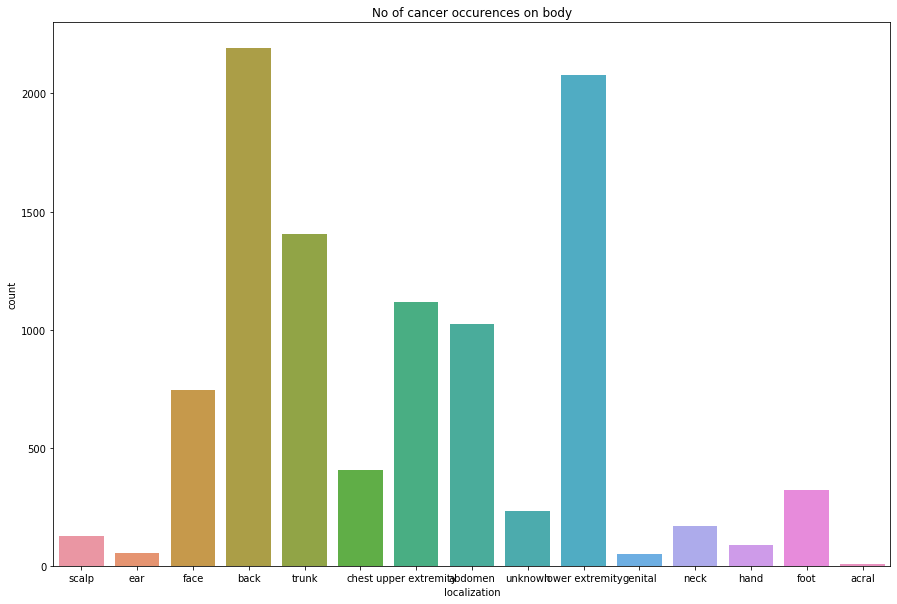

In [11]:
plt.figure(figsize = (15,10))
sns.countplot(df['localization'])
plt.title('No of cancer occurences on body')


Text(0.5, 1.0, 'No of cancer occurences acreoss gender')

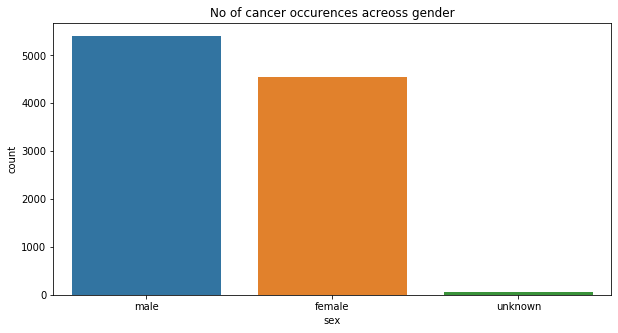

In [12]:
plt.figure(figsize = (10,5))
sns.countplot(df['sex'])
plt.title('No of cancer occurences acreoss gender')

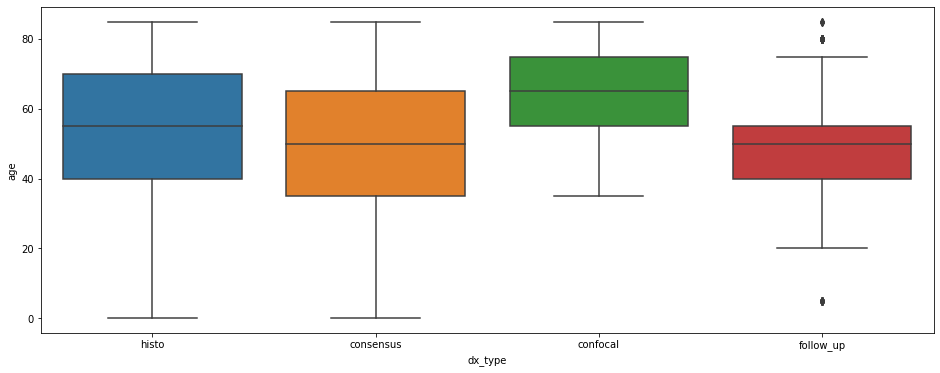

In [13]:
plt.figure(figsize=(16,6))
sns.boxplot(x='dx_type', y='age', data=df)

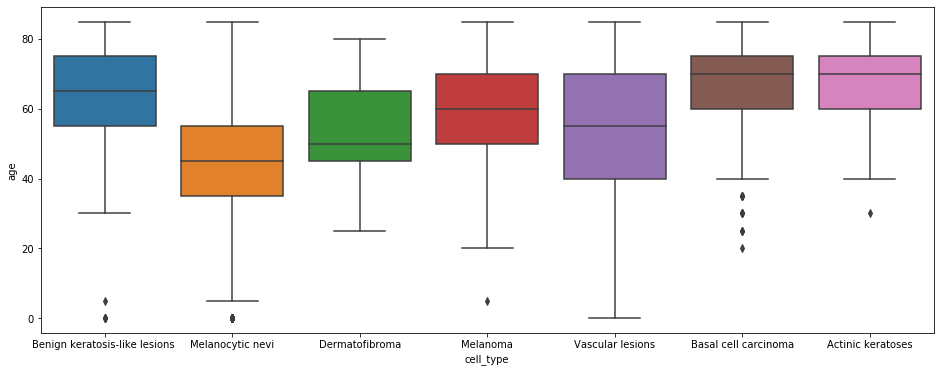

In [14]:
plt.figure(figsize=(16,6))
sns.boxplot(x='cell_type', y='age', data=df)

In [15]:
df_undup = df.groupby('lesion_id').count()

In [16]:
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

lesion_id  image_id  dx  dx_type  age  sex  localization  path  \
0  HAM_0000001         1   1        1    1    1             1     1   
1  HAM_0000003         1   1        1    1    1             1     1   
2  HAM_0000004         1   1        1    1    1             1     1   
3  HAM_0000007         1   1        1    1    1             1     1   
4  HAM_0000008         1   1        1    1    1             1     1   

   cell_type  cell_type_idx  
0          1              1  
1          1              1  
2          1              1  
3          1              1  
4          1              1

In [17]:
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df['duplicates'] = df['lesion_id']
# apply the function to this new column
df['duplicates'] = df['duplicates'].apply(get_duplicates)
df.sample(5)

lesion_id      image_id   dx    dx_type   age     sex localization  \
8119  HAM_0007276  ISIC_0028538   nv      histo  25.0  female      unknown   
4192  HAM_0000831  ISIC_0029226   nv  follow_up  60.0    male      abdomen   
7957  HAM_0003057  ISIC_0033026   nv      histo  45.0  female         back   
4274  HAM_0006383  ISIC_0025183   nv  follow_up  75.0  female        trunk   
1656  HAM_0006037  ISIC_0028082  mel      histo  40.0  female        chest   

                                              path         cell_type  \
8119  data\HAM10000_images_part_1\ISIC_0028538.jpg  Melanocytic nevi   
4192  data\HAM10000_images_part_1\ISIC_0029226.jpg  Melanocytic nevi   
7957  data\HAM10000_images_part_2\ISIC_0033026.jpg  Melanocytic nevi   
4274  data\HAM10000_images_part_1\ISIC_0025183.jpg  Melanocytic nevi   
1656  data\HAM10000_images_part_1\ISIC_0028082.jpg          Melanoma   

      cell_type_idx    duplicates  
8119              4  unduplicated  
4192              4  unduplicated  
7957              4    duplicated  
4274              4  unduplicated  
1656              5    duplicated

In [18]:
df['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [19]:
df.to_csv(os.path.join(data_dir,'updated_metadata.csv'))

In [20]:
data_dir = 'data'
df = pd.read_csv(os.path.join(data_dir, 'updated_metadata.csv'))
df.drop(df.columns[0], axis = 1, inplace = True)
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                           path  \
0  data\HAM10000_images_part_1\ISIC_0027419.jpg   
1  data\HAM10000_images_part_1\ISIC_0025030.jpg   
2  data\HAM10000_images_part_1\ISIC_0026769.jpg   
3  data\HAM10000_images_part_1\ISIC_0025661.jpg   
4  data\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  cell_type_idx  duplicates  
0  Benign keratosis-like lesions               2  duplicated  
1  Benign keratosis-like lesions               2  duplicated  
2  Benign keratosis-like lesions               2  duplicated  
3  Benign keratosis-like lesions               2  duplicated  
4  Benign keratosis-like lesions               2  duplicated

In [21]:
df_undup = df[df['duplicates'] == 'unduplicated']
print(df_undup.shape)
print(df['duplicates'].value_counts())

(5514, 11)
unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64


The data is needed to be split into 3 parts training testing and validation
To create a Test and Validation dataset we need to create a dataframe of original images.

In [29]:
y = df_undup['cell_type_idx']
df_train, df_test = train_test_split(df_undup, test_size = 0.6, random_state = 101, stratify = y)
# y = df_train['cell_type_idx']
# df_train, df_val = train_test_split(df_train, test_size = 0.31, random_state = 101, stratify = y)
# train_df = df[df['duplicates'] == 'duplicated']
# df_train = pd.concat([df[df['duplicates'] == 'duplicated'], df_train])
df_train = df[df['duplicates'] == 'duplicated'].append(df_train)

y = df_test['cell_type_idx']
df_test, df_val = train_test_split(df_test, test_size = 0.33, random_state = 101, stratify = y)
print(df_train.shape)
# print(df_test.shape)
print(df_test.shape)
print(df_val.shape)

(6706, 11)
(2217, 11)
(1092, 11)


In [30]:
# df_val = pd.read_csv('data/validation.csv')
df_train['cell_type'].value_counts()

Melanocytic nevi                  4055
Melanoma                           975
Benign keratosis-like lesions      835
Basal cell carcinoma               409
Actinic keratoses                  236
Vascular lesions                   104
Dermatofibroma                      92
Name: cell_type, dtype: int64

Data is imbalanced, Which is needed to be balanced

In [31]:
# df['cell_type_idx'].value_counts(sort = False)
data_aug_rate = [17, 10, 5, 45, 0, 4, 39]

for i in range(7):
    if data_aug_rate[i]:
        df_train = df_train.append([df_train.loc[df_train['cell_type_idx'] == i, :]] * (data_aug_rate[i] - 1), ignore_index = True)

print(df_train.shape)
df_train['cell_type_idx'].value_counts(sort = False)

(28428, 11)


0    4012
1    4090
2    4175
3    4140
4    4055
5    3900
6    4056
Name: cell_type_idx, dtype: int64

In [32]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  874
Benign keratosis-like lesions      87
Melanoma                           46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   12
Dermatofibroma                      8
Name: cell_type, dtype: int64

In [34]:
df_test['cell_type_idx'].value_counts()

4    1776
2     177
5      92
1      70
0      61
6      26
3      15
Name: cell_type_idx, dtype: int64

In [47]:
# df_train.reset_index()
# df_train.head()
df_test.reset_index(drop = True, inplace = True)
df_test.head()

# df_test.drop(df.columns[0], axis = 1, inplace = True)
df_val.reset_index(drop = True, inplace = True)
df_val.head()
# df_val.drop(df.columns[0], axis = 1, inplace = True)

# df.reset_index(drop = True, inplace = True)
# df.head()

lesion_id      image_id  dx    dx_type   age     sex     localization  \
0  HAM_0003379  ISIC_0030619  nv  follow_up  30.0  female  lower extremity   
1  HAM_0002974  ISIC_0027553  nv  follow_up  80.0    male  upper extremity   
2  HAM_0000911  ISIC_0029087  nv  follow_up  60.0    male  upper extremity   
3  HAM_0003267  ISIC_0024991  nv  follow_up  40.0  female             back   
4  HAM_0002631  ISIC_0028048  nv  follow_up  55.0  female            trunk   

                                           path         cell_type  \
0  data\HAM10000_images_part_2\ISIC_0030619.jpg  Melanocytic nevi   
1  data\HAM10000_images_part_1\ISIC_0027553.jpg  Melanocytic nevi   
2  data\HAM10000_images_part_1\ISIC_0029087.jpg  Melanocytic nevi   
3  data\HAM10000_images_part_1\ISIC_0024991.jpg  Melanocytic nevi   
4  data\HAM10000_images_part_1\ISIC_0028048.jpg  Melanocytic nevi   

   cell_type_idx    duplicates  
0              4  unduplicated  
1              4  unduplicated  
2              4  unduplicated  
3              4  unduplicated  
4              4  unduplicated

In [36]:
df_train.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                           path  \
0  data\HAM10000_images_part_1\ISIC_0027419.jpg   
1  data\HAM10000_images_part_1\ISIC_0025030.jpg   
2  data\HAM10000_images_part_1\ISIC_0026769.jpg   
3  data\HAM10000_images_part_1\ISIC_0025661.jpg   
4  data\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  cell_type_idx  duplicates  
0  Benign keratosis-like lesions               2  duplicated  
1  Benign keratosis-like lesions               2  duplicated  
2  Benign keratosis-like lesions               2  duplicated  
3  Benign keratosis-like lesions               2  duplicated  
4  Benign keratosis-like lesions               2  duplicated

In [37]:
df_test.head()

lesion_id      image_id   dx    dx_type   age     sex     localization  \
0  HAM_0004070  ISIC_0027657   nv  follow_up  40.0    male            trunk   
1  HAM_0000818  ISIC_0029611   nv  follow_up  55.0    male  upper extremity   
2  HAM_0006755  ISIC_0025339  bkl   confocal  65.0    male            scalp   
3  HAM_0007582  ISIC_0027092   nv  follow_up  50.0    male  lower extremity   
4  HAM_0004933  ISIC_0025558   nv  follow_up  45.0  female  lower extremity   

                                           path  \
0  data\HAM10000_images_part_1\ISIC_0027657.jpg   
1  data\HAM10000_images_part_2\ISIC_0029611.jpg   
2  data\HAM10000_images_part_1\ISIC_0025339.jpg   
3  data\HAM10000_images_part_1\ISIC_0027092.jpg   
4  data\HAM10000_images_part_1\ISIC_0025558.jpg   

                        cell_type  cell_type_idx    duplicates  
0                Melanocytic nevi              4  unduplicated  
1                Melanocytic nevi              4  unduplicated  
2  Benign keratosis-like lesions               2  unduplicated  
3                Melanocytic nevi              4  unduplicated  
4                Melanocytic nevi              4  unduplicated

In [38]:
df_train.to_csv(os.path.join(data_dir,'train.csv'))
df_test.to_csv(os.path.join(data_dir,'test.csv'))
df_val.to_csv(os.path.join(data_dir,'validation.csv'))

In [52]:
df_train.sample(n = 5)

lesion_id      image_id   dx    dx_type   age     sex  \
17686  HAM_0000024  ISIC_0027141   df  consensus  45.0  female   
12240  HAM_0000263  ISIC_0033001  bcc      histo  70.0    male   
11330  HAM_0001331  ISIC_0031400  bcc      histo  75.0    male   
23128  HAM_0002723  ISIC_0034050  mel      histo  45.0  female   
1495   HAM_0003957  ISIC_0030653  mel      histo  65.0  female   

          localization                                          path  \
17686  lower extremity  data\HAM10000_images_part_1\ISIC_0027141.jpg   
12240             back  data\HAM10000_images_part_2\ISIC_0033001.jpg   
11330            chest  data\HAM10000_images_part_2\ISIC_0031400.jpg   
23128  lower extremity  data\HAM10000_images_part_2\ISIC_0034050.jpg   
1495              back  data\HAM10000_images_part_2\ISIC_0030653.jpg   

                  cell_type  cell_type_idx    duplicates  
17686        Dermatofibroma              3  unduplicated  
12240  Basal cell carcinoma              1    duplicated  
11330  Basal cell carcinoma              1    duplicated  
23128              Melanoma              5    duplicated  
1495               Melanoma              5    duplicated

In [59]:
grouped = df.groupby('cell_type_idx')

In [174]:
path = grouped.apply(lambda x: x.sample(n = 1))

In [175]:
path

Unnamed: 0    lesion_id      image_id     dx    dx_type  \
cell_type_idx                                                                 
0             9877        9877  HAM_0003401  ISIC_0029002  akiec      histo   
1             2689        2689  HAM_0002069  ISIC_0029331    bcc      histo   
2             667          667  HAM_0006907  ISIC_0027953    bkl      histo   
3             1129        1129  HAM_0005492  ISIC_0032138     df      histo   
4             6330        6330  HAM_0005833  ISIC_0030431     nv  follow_up   
5             1649        1649  HAM_0005748  ISIC_0034065    mel      histo   
6             2357        2357  HAM_0004776  ISIC_0033158   vasc      histo   

                     age     sex     localization  \
cell_type_idx                                       
0             9877  55.0    male             face   
1             2689  50.0    male  lower extremity   
2             667   35.0  female  lower extremity   
3             1129  35.0  female  lower extremity   
4             6330  35.0  female             foot   
5             1649  50.0    male            trunk   
6             2357  45.0  female            chest   

                                                            path  \
cell_type_idx                                                      
0             9877  data\HAM10000_images_part_1\ISIC_0029002.jpg   
1             2689  data\HAM10000_images_part_2\ISIC_0029331.jpg   
2             667   data\HAM10000_images_part_1\ISIC_0027953.jpg   
3             1129  data\HAM10000_images_part_2\ISIC_0032138.jpg   
4             6330  data\HAM10000_images_part_2\ISIC_0030431.jpg   
5             1649  data\HAM10000_images_part_2\ISIC_0034065.jpg   
6             2357  data\HAM10000_images_part_2\ISIC_0033158.jpg   

                                         cell_type  cell_type_idx  \
cell_type_idx                                                       
0             9877               Actinic keratoses              0   
1             2689            Basal cell carcinoma              1   
2             667   Benign keratosis-like lesions               2   
3             1129                  Dermatofibroma              3   
4             6330                Melanocytic nevi              4   
5             1649                        Melanoma              5   
6             2357                Vascular lesions              6   

                      duplicates  
cell_type_idx                     
0             9877    duplicated  
1             2689  unduplicated  
2             667   unduplicated  
3             1129  unduplicated  
4             6330  unduplicated  
5             1649    duplicated  
6             2357    duplicated

(600, 450)
(600, 450)
(600, 450)
(600, 450)
(600, 450)
(600, 450)
(600, 450)


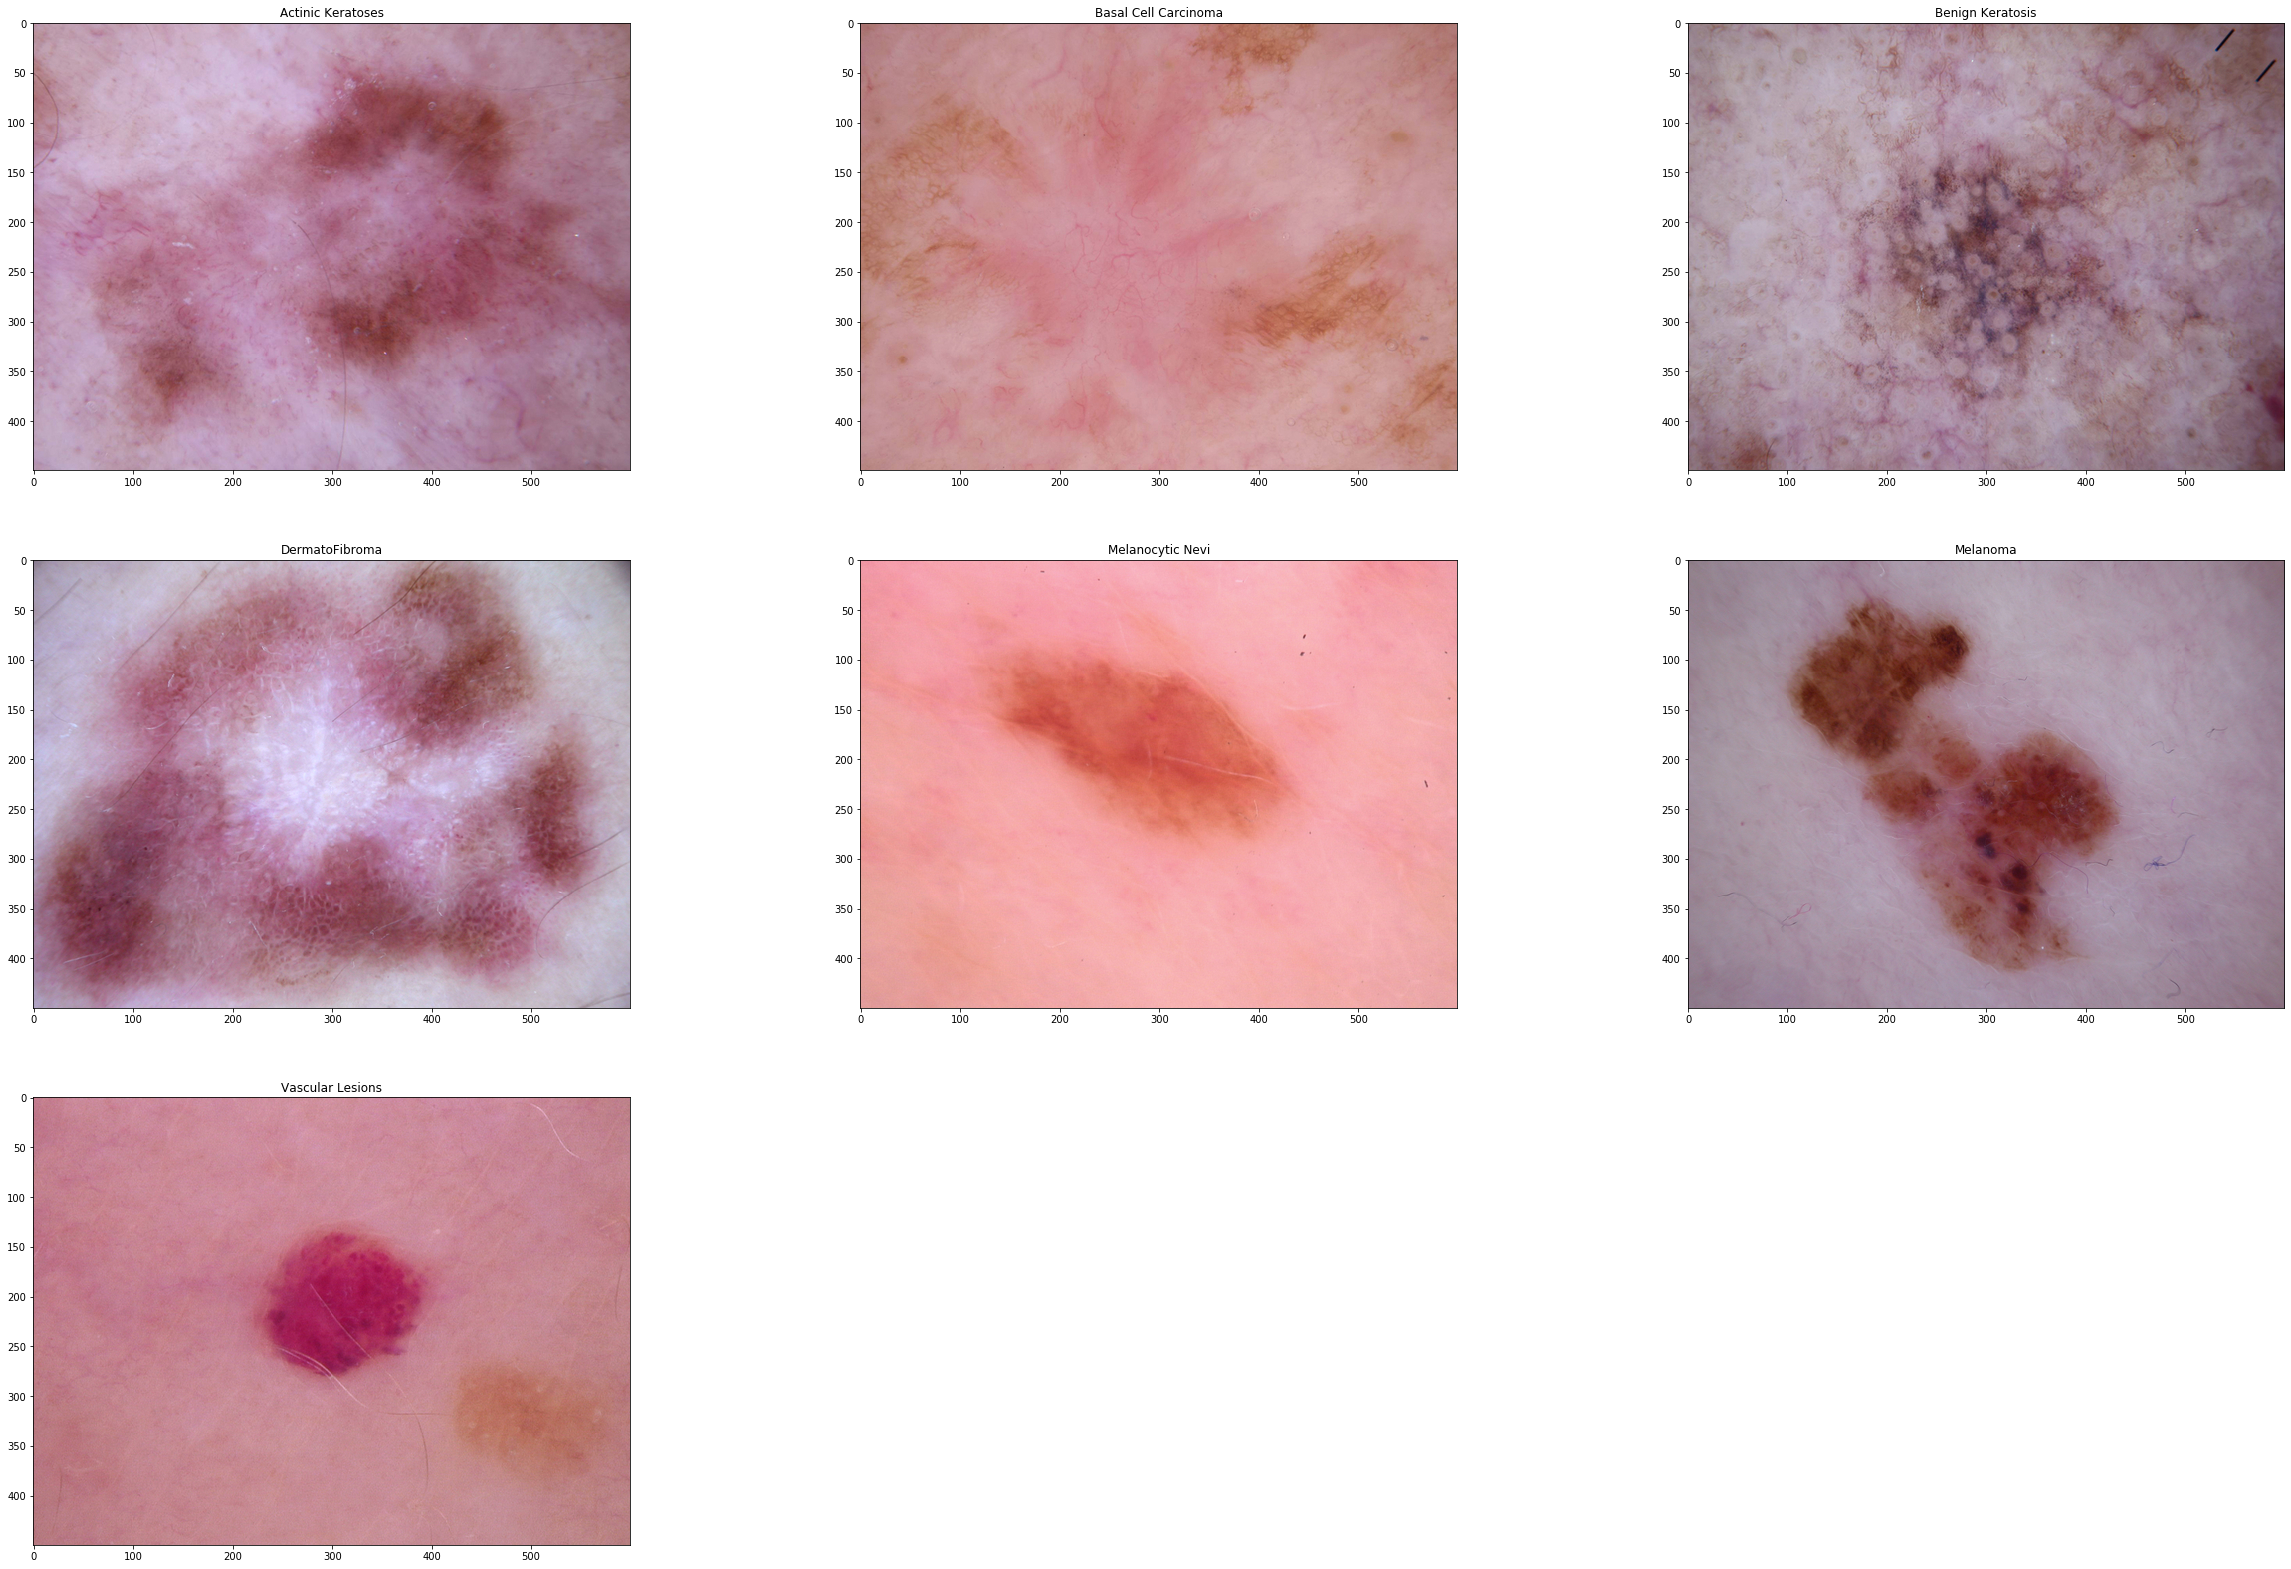

In [173]:
# %pylab inline
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# fig=plt.figure(figsize=(8, 8))

# for i in range(1, 7)
# img=mpimg.imread(path[0])
# imgplot = plt.imshow(img)
# plt.show()



def show_images(images, cols = 3, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        img = Image.open(image)
#         print(img.size)
#         if img.ndim == 2:
#             plt.gray()
        plt.imshow(img)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.savefig('graphs/rawimage.jpeg')
    plt.show()
    

    
titles = ['Actinic Keratoses', 'Basal Cell Carcinoma', 'Benign Keratosis', 'DermatoFibroma', 'Melanocytic Nevi', 'Melanoma', 'Vascular Lesions']
show_images(path, titles = titles)

Now the data is in suitable format for the modelling.